Home Sales Data Details in Istanbul

src : https://www.kaggle.com/datasets/emrahaydemr/home-sales-data-details-in-istanbul/data

column :179

In [43]:
!pip install pip==23.2.1 setuptools==65.5.1

In [44]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [45]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "Home Sale Data.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/Home Sale Data.csv


In [46]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [47]:
# Load dataset
df = pd.read_csv(data_location, delimiter=';')
df.head(5)

,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
0,Tuzla,Aydınlı Mh.,165.000 TL,04.01.2020,50,40.0,1+1,5-10 between,5,13,Natural Gas (Combi),1,Absent,Yes,Free,Yes,From owner,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.08.2020
1,Fatih,Katip Kasım Mh.,207.000 TL,06.01.2020,42,42.0,1+1,31 and more than,Ground floor,3,Floor Heating,1,Absent,No,Free,Yes,From bank,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
2,Çekmeköy,Çatalmeşe Mh.,153.000 TL,31.12.2019,55,45.0,1+1,1,Kot 1,7,Natural Gas (Combi),1,Absent,No,Property owner,Yes,From owner,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
3,Çekmeköy,Mehmet Akif Ersoy Mah.,205.000 TL,29.12.2019,62,46.0,1+1,0,High entrance,5,Natural Gas (Combi),1,Absent,No,Property owner,Yes,From owner,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
4,Küçükçekmece

In [48]:
df.shape

(34843, 179)

In [49]:
df.tail()

,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
34838,Sarıyer,Ayazağa Mh.,5.650.000 TL,02.01.2020,270,185.0,4+1,0,9,9,Center (Share Meter),2,Available,No,Free,Yes,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.08.2020
34839,Bakırköy,Ataköy 2-5-6. Kısım Mh.,12.000.000 TL,03.01.2020,289,250.0,4.5+1,0,8,16,Center (Share Meter),3,Available,Yes,Free,No,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
34840,Sarıyer,Maslak Mah.,2.700.000 TL,03.01.2020,311,310.0,3+1,1,14,16,Center (Share Meter),2,Available,No,Free,No,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,01.08.2020
34841,Fatih,İskenderpaşa Mh.,775.000 TL,28.12.2019,145,121.0,3+1,0,4,7,Natural Gas (Combi),2,Available,Yes,Property owner,Yes,From owner,Yes,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34843 entries, 0 to 34842
Columns: 179 entries, District to Pick Up Data Time
dtypes: float64(1), int64(161), object(17)
memory usage: 47.6+ MB


In [51]:
df.isnull().sum().sort_values(ascending=False).head(20)


m² (Net)             28
Handle / Railing      0
Toilet                0
Swimming pool         0
The mall              0
municipality          0
Mosque                0
Cemevi                0
Next to sea shore     0
Pharmacy              0
Garage / Shop Top     0
Fair                  0
Hospital              0
Synagogue             0
The church            0
High school           0
Market                0
Park.1                0
Police station        0
The health clinic     0
dtype: int64

In [52]:
# Step 1: Remove duplicate columns (e.g., multiple 'Elevator', 'Balcony')
df = df.loc[:, ~df.columns.duplicated()]

In [53]:
# Step 2: Drop columns with all missing values (if any)
df.dropna(axis=1, how='all', inplace=True)

In [54]:
# Step 2: Drop columns with all missing values (if any)
df.dropna(axis=1, how='all', inplace=True)

In [55]:
# Step 3: Fill missing values (you can customize)
df.fillna("Unknown", inplace=True)

In [56]:
df.shape

(34843, 179)

In [57]:
pd.set_option('display.max_columns', None)
df.columns.tolist()

['District',
 'Neighborhood',
 'Price',
 'Adrtisement Date',
 'm² (Gross)',
 'm² (Net)',
 'Number of rooms',
 'Building Age',
 'Floor location',
 'Number of floors',
 'Heating',
 'Number of bathrooms',
 'Balcony',
 'Furnished',
 'Using status',
 'Available for Loan',
 'From who',
 'Swap',
 'Front West',
 'Front East',
 'Front South',
 'Front North',
 'ADSL',
 'Wood Joinery',
 'Smart House',
 'Alarm (Thief)',
 'Alarm (Fire)',
 'Alaturka Toilet',
 'Aluminum joinery',
 'American Door',
 'American kitchen',
 'Built-in on',
 'Elevator',
 'Balcony.1',
 'Barbecue',
 'Household appliances',
 'Painted',
 'Dishwasher',
 'Refrigerator',
 'Wall paper',
 'Shower',
 "Parents' Bathroom",
 'Fiber Internet',
 'On',
 'Dressing room',
 'Closet',
 'Video intercom',
 'Hilton Bathroom',
 'Intercom System',
 'Insulating glass',
 'Jacuzzi',
 'Plasterboard',
 'Cellar',
 'Air conditioning',
 'Tub',
 'Laminate Floor',
 'Marley',
 'Furniture',
 'Kitchen (Built-in)',
 'Kitchen (Laminate)',
 'Kitchen Natural Gas',


In [58]:
# This tells pandas to display all columns without truncation
pd.set_option('display.max_columns', None)

# Now display a specific row — for example, the first row
print(df.iloc[0])

District                   Tuzla
Neighborhood         Aydınlı Mh.
Price                 165.000 TL
Adrtisement Date      04.01.2020
m² (Gross)                    50
                        ...     
Rerse Duplex                   0
Triplex                        0
Ground floor                   0
Roof Duplex                    0
Pick Up Data Time     01.08.2020
Name: 0, Length: 179, dtype: object


In [59]:
df.sample(1)  # shows 1 random full row


,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
15048,Sancaktepe,Yenidoğan Mh.,200.000 TL,03.01.2020,100,88.0,2+1,4,High entrance,4,Natural Gas (Combi),2,Absent,No,Property owner,Yes,From the real estate office,Yes,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,01.08.2020


In [60]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()


District                 39
Neighborhood            609
Price                  2050
Adrtisement Date        160
m² (Net)                301
Number of rooms          32
Building Age             11
Floor location           42
Number of floors         30
Heating                  16
Number of bathrooms       8
Balcony                   3
Furnished                 3
Using status              3
Available for Loan        3
From who                  4
Swap                      2
Pick Up Data Time         4
dtype: int64

In [61]:
df.drop(['Adrtisement Date', 'Pick Up Data Time'], axis=1, inplace=True)

In [62]:
# Remove unwanted characters (like commas, spaces, etc.) and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['m² (Net)'] = pd.to_numeric(df['m² (Net)'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Optional: Convert other numeric-like columns too
numeric_cols = ['m² (Gross)', 'Number of rooms', 'Building Age', 'Number of floors', 'Number of bathrooms']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')


In [63]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

District               39
Neighborhood          609
Floor location         42
Heating                16
Balcony                 3
Furnished               3
Using status            3
Available for Loan      3
From who                4
Swap                    2
dtype: int64

In [64]:
df['Floor location'].unique()

array(['5', 'Ground floor', 'Kot 1', 'High entrance', 'Garden Floor', '2',
       '4', '6', '1', 'Entrance floor', '3', 'Basement', 'Kot 2', 'Kot 3',
       '13', '7', '10', '11', 'Kot 4', '9', '27', '25', '12',
       '30  and more than', '15', '8', '20', '14', '16', '22', '19', '23',
       '18', 'Penthouse', 'Villa type', '21', '17', '24', '26', '29',
       'Private', '28'], dtype=object)

In [65]:
floor_location_mapping = {
    'Ground floor': 42,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '11': 11,
    '12': 12,
    '13': 13,
    '14': 14,
    '15': 15,
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19,
    '20': 20,
    '21': 21,
    '22': 22,
    '23': 23,
    '24': 24,
    '25': 25,
    '26': 26,
    '27': 27,
    '28': 28,
    '29': 29,
    '30 and more than': 30,
    'Villa type': 31,
    'High entrance': 32,
    'Entrance floor': 33,
    'Basement': 34,
    'Kot 1': 35,
    'Kot 2': 36,
    'Kot 3': 37,
    'Kot 4': 38,
    'Penthouse': 39,
    'Private': 40,
    'Garden Floor': 41
}

# Replace floor location with mapped values
df['Floor location'] = df['Floor location'].map(floor_location_mapping)

# Fill NaN values with 0 (means unknown/missing)
df['Floor location'] = df['Floor location'].fillna(0).astype(int)

# Confirm changes
print(df['Floor location'].unique())


0     5
1    42
2    35
3    32
4    41
Name: Floor location, dtype: int64


In [66]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

District               39
Neighborhood          609
Heating                16
Balcony                 3
Furnished               3
Using status            3
Available for Loan      3
From who                4
Swap                    2
dtype: int64

In [68]:
df['Floor location'].unique()

array([ 5, 42, 35, 32, 41,  2,  4,  6,  1, 33,  3, 34, 36, 37, 13,  7, 10,
       11, 38,  9, 27, 25, 12,  0, 15,  8, 20, 14, 16, 22, 19, 23, 18, 39,
       31, 21, 17, 24, 26, 29, 40, 28])

In [69]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price                  4727
m² (Net)                 28
Number of bathrooms      60
dtype: int64


In [73]:
# Fill NaN values with 0 (means unknown/missing)
df['Number of bathrooms'] = df['Number of bathrooms'].fillna(0).astype(int)
print(df['Number of bathrooms'].unique().tolist())

[1, 2, 3, 4, 0, 5, 6]


In [74]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price       4727
m² (Net)      28
dtype: int64


In [75]:
print(df['m² (Net)'].unique().tolist())

[40.0, 42.0, 45.0, 46.0, 55.0, 60.0, 62.0, 64.0, 65.0, 67.0, 68.0, 70.0, 73.0, 75.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 90.0, 95.0, 96.0, 100.0, 105.0, 106.0, 110.0, 115.0, 116.0, 118.0, 120.0, 122.0, 130.0, 135.0, 138.0, 150.0, 160.0, 180.0, 200.0, 217.0, nan, 140.0, 43.0, 187.0, 50.0, 72.0, 78.0, 165.0, 220.0, 107.0, 125.0, 117.0, 77.0, 170.0, 87.0, 98.0, 58.0, 79.0, 15.0, 30.0, 47.0, 48.0, 51.0, 54.0, 59.0, 66.0, 69.0, 74.0, 89.0, 91.0, 92.0, 94.0, 97.0, 101.0, 108.0, 126.0, 128.0, 132.0, 136.0, 137.0, 139.0, 142.0, 145.0, 152.0, 156.0, 157.0, 159.0, 166.0, 169.0, 175.0, 185.0, 189.0, 190.0, 197.0, 209.0, 210.0, 215.0, 225.0, 230.0, 235.0, 240.0, 250.0, 270.0, 310.0, 325.0, 400.0, 18.0, 22.0, 27.0, 31.0, 32.0, 33.0, 34.0, 35.0, 37.0, 38.0, 39.0, 41.0, 44.0, 49.0, 52.0, 53.0, 57.0, 61.0, 63.0, 71.0, 76.0, 81.0, 88.0, 93.0, 99.0, 102.0, 103.0, 104.0, 109.0, 112.0, 113.0, 114.0, 119.0, 121.0, 123.0, 124.0, 127.0, 131.0, 141.0, 143.0, 144.0, 148.0, 149.0, 153.0, 154.0, 155.0, 158.0, 16

In [76]:
df['m² (Net)'] = df['m² (Net)'].fillna(0).astype(int)
print(df['m² (Net)'].unique().tolist())

[40, 42, 45, 46, 55, 60, 62, 64, 65, 67, 68, 70, 73, 75, 80, 82, 83, 84, 85, 86, 90, 95, 96, 100, 105, 106, 110, 115, 116, 118, 120, 122, 130, 135, 138, 150, 160, 180, 200, 217, 0, 140, 43, 187, 50, 72, 78, 165, 220, 107, 125, 117, 77, 170, 87, 98, 58, 79, 15, 30, 47, 48, 51, 54, 59, 66, 69, 74, 89, 91, 92, 94, 97, 101, 108, 126, 128, 132, 136, 137, 139, 142, 145, 152, 156, 157, 159, 166, 169, 175, 185, 189, 190, 197, 209, 210, 215, 225, 230, 235, 240, 250, 270, 310, 325, 400, 18, 22, 27, 31, 32, 33, 34, 35, 37, 38, 39, 41, 44, 49, 52, 53, 57, 61, 63, 71, 76, 81, 88, 93, 99, 102, 103, 104, 109, 112, 113, 114, 119, 121, 123, 124, 127, 131, 141, 143, 144, 148, 149, 153, 154, 155, 158, 164, 168, 171, 172, 173, 176, 177, 179, 181, 186, 188, 193, 195, 202, 205, 212, 242, 245, 260, 265, 275, 280, 285, 290, 295, 300, 330, 350, 352, 435, 440, 445, 550, 56, 146, 167, 20, 29, 134, 151, 163, 174, 183, 184, 214, 223, 247, 267, 444, 521, 133, 360, 402, 203, 192, 370, 111, 255, 216, 340, 490, 208, 1

In [77]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price    4727
dtype: int64


In [79]:
# Calculate the median of the 'Price' column
median_price = df['Price'].median()

# Fill NaN values with the median
df['Price'].fillna(median_price, inplace=True)

# Confirm no more nulls in 'Price'
print(df['Price'].isnull().sum())
print(df.isnull().sum()[df.isnull().sum() > 0])

0
Series([], dtype: int64)


In [80]:
from sklearn.preprocessing import LabelEncoder

# Select all categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Check the result
print("\nLabel encoding applied. Sample data:\n")
print(df[categorical_cols].head())



Label encoding applied. Sample data:

   District  Neighborhood  Heating  Balcony  Furnished  Using status  \
0        31            57       10        0          2             0   
1        17           264        7        0          0             0   
2        34           554       10        0          0             1   
3        34           329       10        0          0             1   
4        23           225       10        0          0             1   

   Available for Loan  From who  Swap  
0                   2         1     0  
1                   2         0     0  
2                   2         1     1  
3                   2         1     1  
4                   2         1     0  


In [82]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

Series([], dtype: float64)

Price statistics:

Minimum Price     : 20.0
Maximum Price     : 14760000.0
Mean Price        : 15425.248036334413
Median Price      : 370.0
25th Percentile   : 280.0
75th Percentile   : 500.0


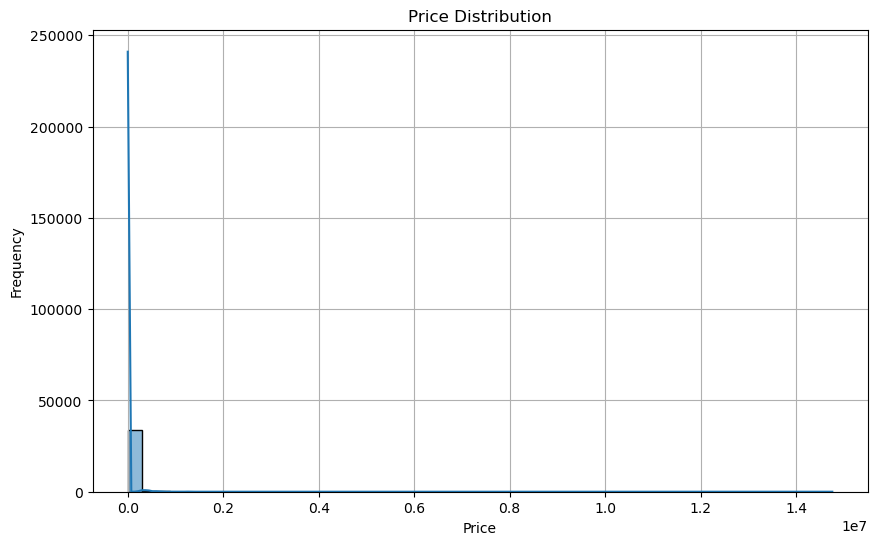

In [83]:
# Basic statistics about the Price column
print("Price statistics:\n")
print("Minimum Price     :", df['Price'].min())
print("Maximum Price     :", df['Price'].max())
print("Mean Price        :", df['Price'].mean())
print("Median Price      :", df['Price'].median())
print("25th Percentile   :", df['Price'].quantile(0.25))
print("75th Percentile   :", df['Price'].quantile(0.75))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [86]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

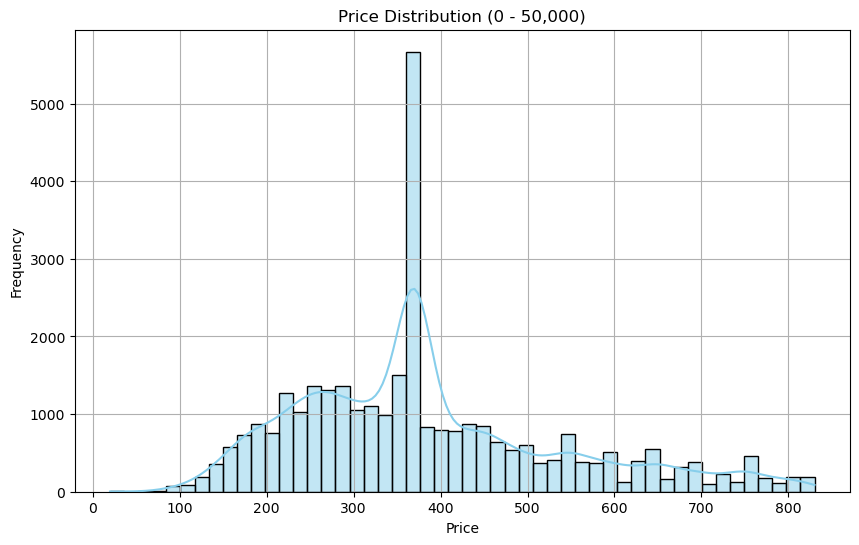

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution (0 - 50,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [89]:
# Separate target and features
y = df['Price']  # Capital P as per your column
X = df.drop(columns=['Price'])

print("✅ Target and features are ready!")
print("🎯 y (target):", y.name)
print("🧠 X shape:", X.shape)


✅ Target and features are ready!
🎯 y (target): Price
🧠 X shape: (32562, 176)


In [90]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete!")
print("🧪 X_train shape:", X_train.shape)
print("🧪 X_test shape :", X_test.shape)
print("🎯 y_train shape:", y_train.shape)
print("🎯 y_test shape :", y_test.shape)


✅ Data split complete!
🧪 X_train shape: (26049, 176)
🧪 X_test shape : (6513, 176)
🎯 y_train shape: (26049,)
🎯 y_test shape : (6513,)


# FInd Algorithem = XGboot

In [146]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

In [147]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [148]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# 2. CUSTOM WHALE OPTIMIZATION ALGORITHM

In [149]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm (Scaled: 60 whales, 40 iterations)"""
    def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # Linearly decreases from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # Linearly decreases from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate and update best
                fitness[i] = self.func(whales[i])
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness


In [150]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and scaled to 60 players and 40 games."""
    def __init__(self, func, dim, lb, ub, n_players=60, max_games=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players and their roles (0 = defensive, 1 = offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])

        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.1 + (0.4 * game / self.max_games)  # Adjusted scaling  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    step = np.random.normal(0, 0.25 * (1 - game / self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # 10% chance to switch role
                if random.random() < 0.1:
                    roles[i] = 1 - roles[i]

            # Evaluate new population and apply survival conditions
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1 * best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness


In [151]:
class PSH_Hyptrite:
    """2x Scaled PSH with bounds checking and hypersphere sampling."""
    def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - (iter/self.max_iter)**0.5)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 5)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

In [152]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 60")
        print(f"- Generations: 40")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # 3. Initialize population
    population = toolbox.population(n=60)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(40):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 39:
            print(f"Gen {gen+1:02d}/40 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [153]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 60 particles")  # Updated to 60 particles
        print(f"- Iterations: 40")  # Updated to 40 iterations
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 60 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=60,
        maxiter=40,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [154]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 60 whales")  # Updated to 60
        print(f"- Max iterations: 40")  # Updated to 40
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")
        
    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [155]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 60 (30 offensive, 30 defensive)")  # Updated to 60 players
        print(f"- Max games: 40")  # Updated to 40 max games
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=60,
        max_games=40
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [156]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 60")
        print(f"- Max iterations: 40")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [157]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 60
- Generations: 40
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 176 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/40 | Best MSE: 11389.617206 | Avg MSE: 12455.794315
Gen 06/40 | Best MSE: 11213.547655 | Avg MSE: 11308.956723
Gen 11/40 | Best MSE: 11022.984427 | Avg MSE: 11107.394039
Gen 16/40 | Best MSE: 10940.017894 | Avg MSE: 10988.549778
Gen 21/40 | Best MSE: 10940.017894 | Avg MSE: 10940.017894
Gen 26/40 | Best MSE: 10940.017894 | Avg MSE: 10940.017894
Gen 31/40 | Best MSE: 10940.017894 | Avg MSE: 10940.017894
Gen 36/40 | Best MSE: 10940.017894 | Avg MSE: 10940.017894
Gen 40/40 | Best MSE: 10940.017894 | Avg MSE: 10940.017894

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 10940.017894
▶ Time elapsed: 1104.67 seconds
▶ Features selected: 102/176 (42.0% reduction)

▶ Selected features:
1. District
2. Neighborhood
3. m² (Gross)
4.

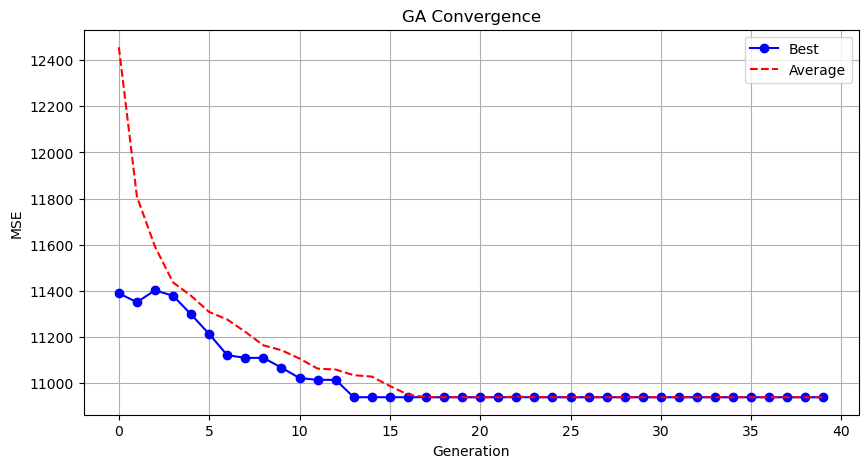

Genetic Algorithm completed successfully with MSE: 10940.0179

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 60 particles
- Iterations: 40
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 176 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 15099.645980
Best after iteration 1: [0.6871811  0.35100314 0.88198424 0.63944297 0.52624657 0.63895567
 0.56238974 0.65709942 0.08284341 0.890428   0.63830452 0.14231804
 0.39464272 0.77710052 0.28779189 0.39159375 0.49163325 0.11732242
 0.64825993 0.65073226 0.52112224 0.0868414  0.57335739 0.18672259
 0.98161607 0.94844316 0.22103597 0.41990268 0.1685304  0.43037934
 0.01723726 0.38634767 0.09140023 0.29025286 0.51269674 0.09981133
 0.43815917 0.15291056 0.11238932 0.76903324 0.21617446 0.81569065
 0.99870266 0.35084916 0.19611761 0.24300403 0.56128227 0.74466438
 0.26155696 0.0111789 

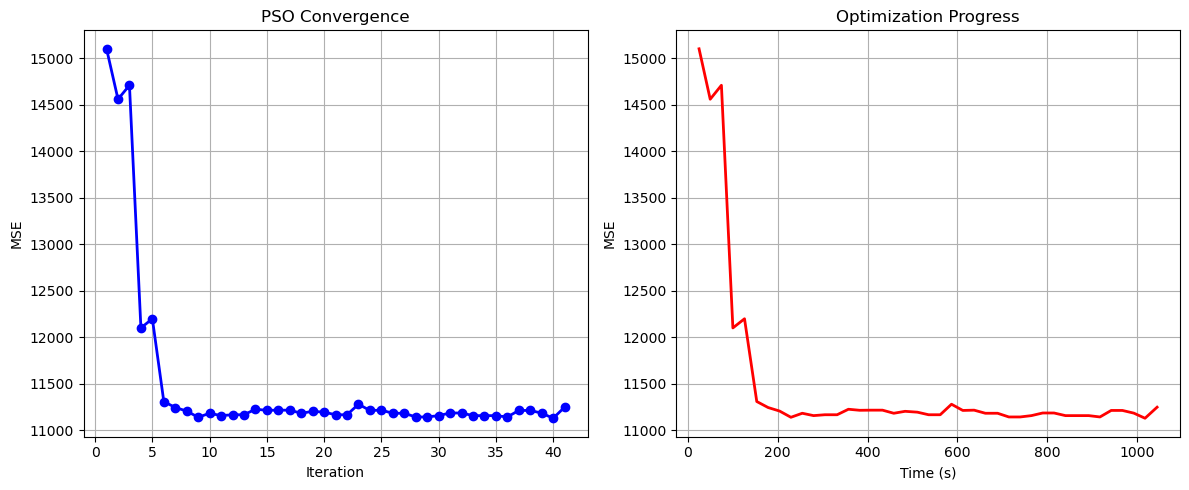

Particle Swarm Optimization completed successfully with MSE: 11022.2865

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 60 whales
- Max iterations: 40
- Spiral coefficient (b): 1.0
- Search space: 176 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 11063.349108

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 11063.349108
▶ Time elapsed: 1408.20 seconds
▶ Features selected: 173/176 (1.7% reduction)

▶ Selected features:
1. District
2. Neighborhood
3. m² (Gross)
4. m² (Net)
5. Number of rooms
6. Building Age
7. Floor location
8. Number of floors
9. Heating
10. Number of bathrooms
11. Balcony
12. Furnished
13. Using status
14. Available for Loan
15. From who
16. Swap
17. Front West
18. Front East
19. Front South
20. Front North
21. ADSL
22. Wood Joinery
23. Smart House
24. Alarm (Thief)
25. Alarm (Fire)
26. Alaturka Toilet
27. Aluminum joinery
28. American Door
29. American kitchen
30. B

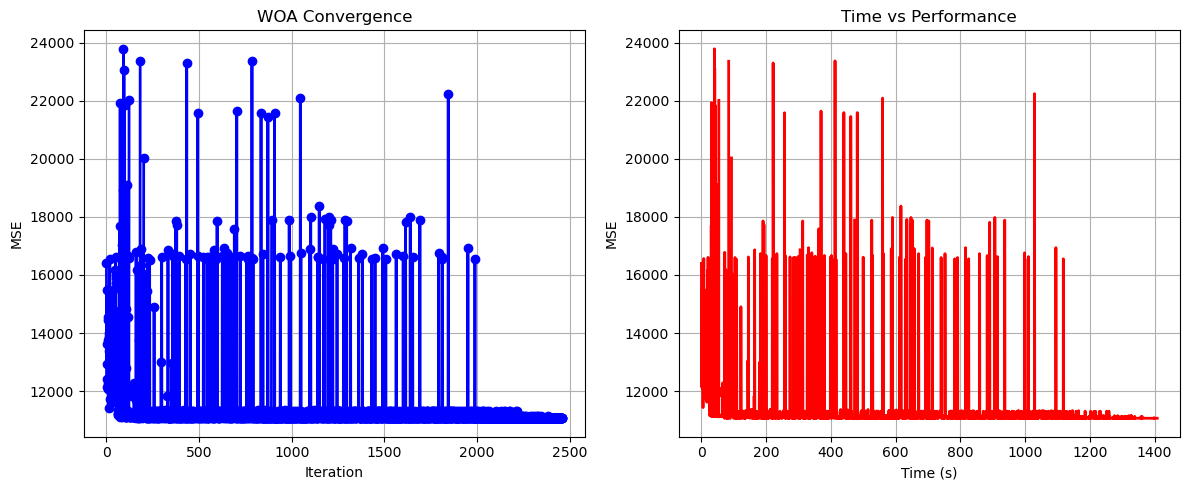

Whale Optimization completed successfully with MSE: 11063.3491

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 60 (30 offensive, 30 defensive)
- Max games: 40
- Search space: 176 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 10939.258387
▶ Time elapsed: 923.80 seconds
▶ Features selected: 71/176 (59.7% reduction)

▶ Selected features:
1. District
2. Neighborhood
3. m² (Gross)
4. Number of rooms
5. Building Age
6. Floor location
7. Number of floors
8. Heating
9. Number of bathrooms
10. Balcony
11. Using status
12. Available for Loan
13. Front North
14. Wood Joinery
15. Smart House
16. Alaturka Toilet
17. American Door
18. Built-in on
19. Elevator
20. Refrigerator
21. Wall paper
22. Fiber Internet
23. On
24. Intercom System
25. Insulating glass
26. Tub
27. Laminate Floor
28. Marley
29. Furniture
30. Kitchen (Laminate)
31. Ceramic Floor
32. Set Top Cooker
33. Thermosiphon
34. Face Recogn

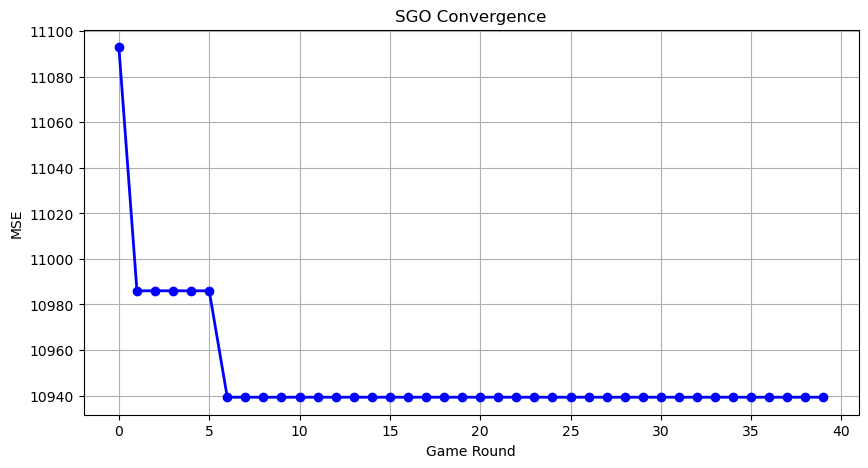

Squid Game Optimizer completed successfully with MSE: 10939.2584

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 60
- Max iterations: 40
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 176 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 11050.233424 | Radius: 0.0125

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 11050.233424
▶ Time elapsed: 3111.95 seconds
▶ Features selected: 93/176 (47.2% reduction)

▶ Selected features (with weights):
1. District (weight: 0.629)
2. Neighborhood (weight: 0.658)
3. m² (Gross) (weight: 0.992)
4. m² (Net) (weight: 0.902)
5. Number of rooms (weight: 0.621)
6. Building Age (weight: 0.853)
7. Floor location (weight: 0.529)
8. Number of floors (weight: 0.808)
9. Heating (weight: 0.599)
10. Number of bathrooms (weight: 0.649)
11. Using status (weight: 0.797)
12. Front West (weight: 0.879)
13. Front East (weight: 0.598)
14. Fro

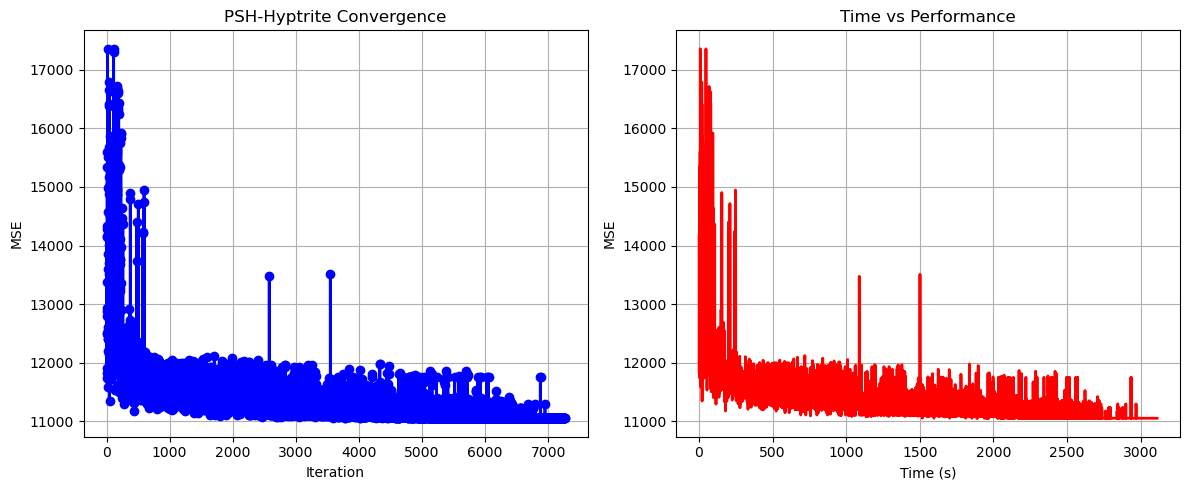

PSH-Hyptrite completed successfully with MSE: 11050.2334


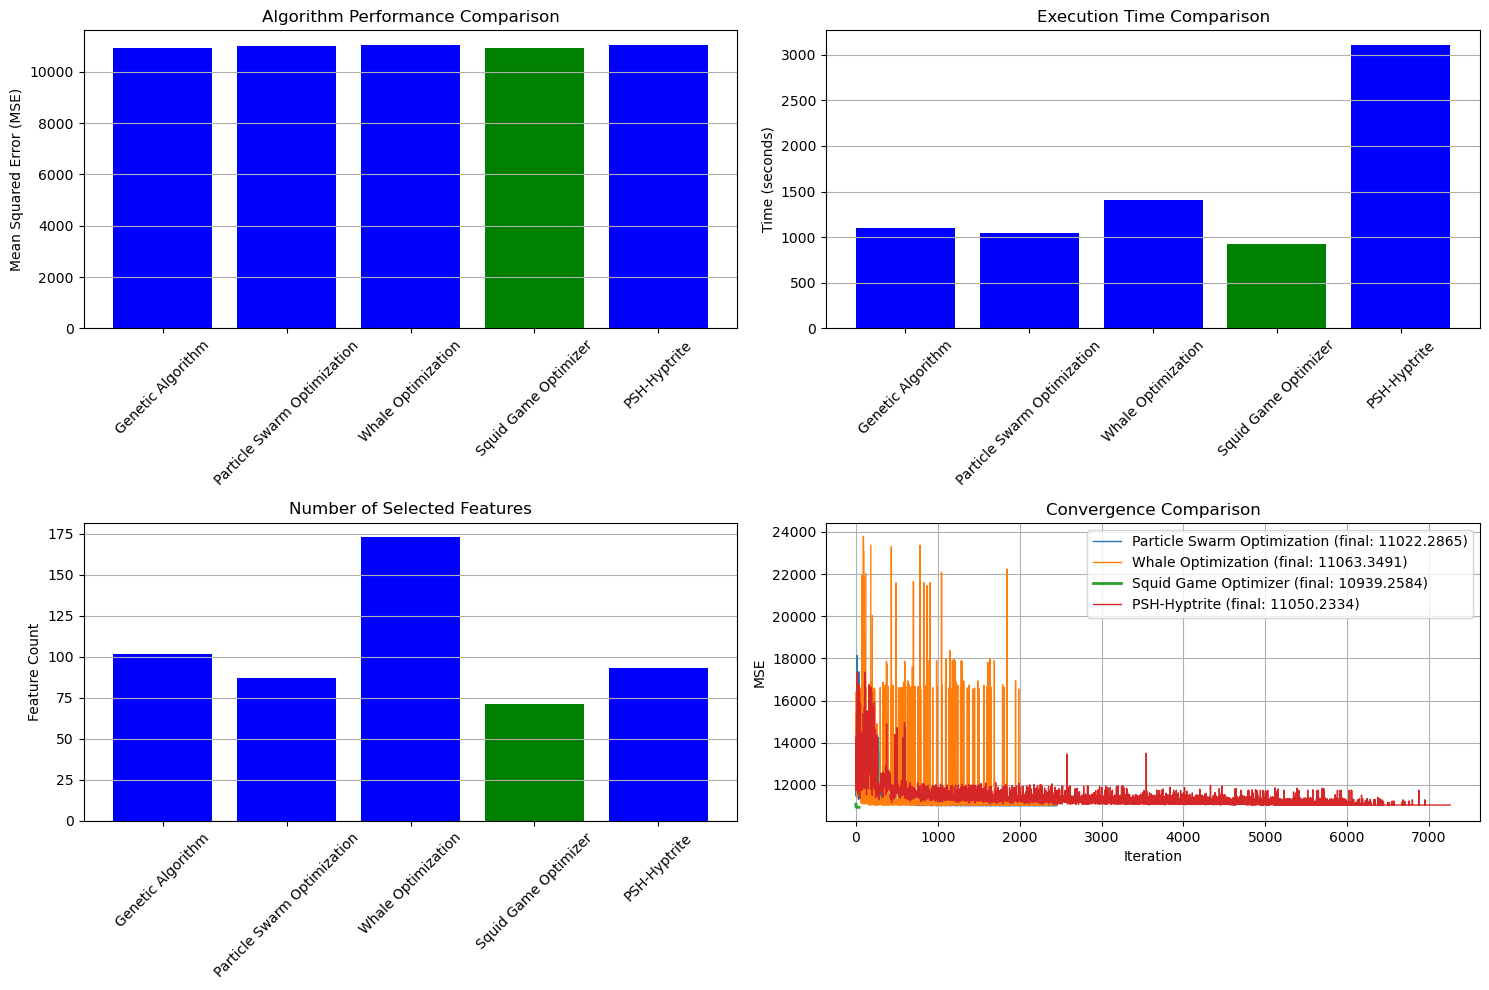


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Squid Game Optimizer
📉 Best MSE Achieved: 10939.258387
⏱️ Execution Time: 923.80 seconds
🔢 Features Selected: 71

Selected Features:
1. District
2. Neighborhood
3. m² (Gross)
4. Number of rooms
5. Building Age
6. Floor location
7. Number of floors
8. Heating
9. Number of bathrooms
10. Balcony
11. Using status
12. Available for Loan
13. Front North
14. Wood Joinery
15. Smart House
16. Alaturka Toilet
17. American Door
18. Built-in on
19. Elevator
20. Refrigerator
21. Wall paper
22. Fiber Internet
23. On
24. Intercom System
25. Insulating glass
26. Tub
27. Laminate Floor
28. Marley
29. Furniture
30. Kitchen (Laminate)
31. Ceramic Floor
32. Set Top Cooker
33. Thermosiphon
34. Face Recognition & Fingerprint
35. Fireplace
36. Security
37. Generator
38. Cable TV
39. Closed Garage
40. With Private Pool
41. Car park
42. Playground
43. Tennis court
44. Swimming Pool (Indoor)
45. Elevator.2
46. Toilet
47. Swimming pool
48. The mall
49. Next to sea shore


In [158]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)